<a href="https://colab.research.google.com/github/arjangvt/Projects/blob/main/VehicleBinaryClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A CNN model for vehicle detection using Tensorflow and keras. The images were downloaded using "Download Images" chrome extension. In this case I changed the model for binary classification for two car makes Honda and Toyota. <br>
Toyota is Labled as 0 and Honda is labled as 1. <bt>

---
To run this code:
1- Mount the your Colab to the Google drive (The code is already there)
2- On your Google drive create folders below:
*   data
  * honda
  * toyota
*   logs
*   model

3- The data can be found on github. A small dataset for anyone who wants to test it is provided in the git repo. <br>
The data contains honda folder with 761 and Toyata with 627 images.
We are still working on the larger dataset with more car makes and models. The latest version is available upon user's request.

---

Written by: Arjang Fahim <br>
Date: 12/8/2018 <br>
Last update: 11/2/2020 <br>

# Step 1: Setup and load data

## 1.1: Install Dependecies and Setup

In [ ]:
# Installing tensorflow

In [1]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
len(gpus)

1

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.2: Remove dodg images

In [6]:
import cv2
import imghdr
import matplotlib.pyplot as plt

In [9]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CNNToyotaHondaBinaryClassifier/data'

In [10]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [11]:
img = cv2.imread(os.path.join(data_dir, 'toyota', '001.jpg'))

In [12]:
img.shape

(381, 900, 3)

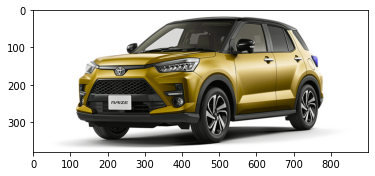

In [13]:
plt.imshow(img)

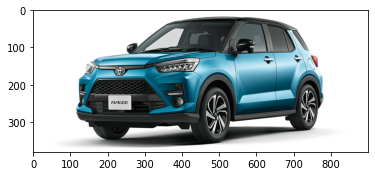

In [14]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print('Image not in extension list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

In [20]:
for image_class in os.listdir(data_dir):
  print(image_class)

honda
.ipynb_checkpoints
toyota


## 1.3: Load Data

In [16]:
import numpy as np

In [21]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1204 files belonging to 2 classes.


In [22]:
type(data), len(data)

(tensorflow.python.data.ops.dataset_ops.BatchDataset, 38)

In [23]:
data_iterator = data.as_numpy_iterator()
type(data_iterator)
batch = data_iterator.next()

In [24]:
batch[0].shape

(32, 256, 256, 3)

In [25]:
batch[1]

array([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int32)

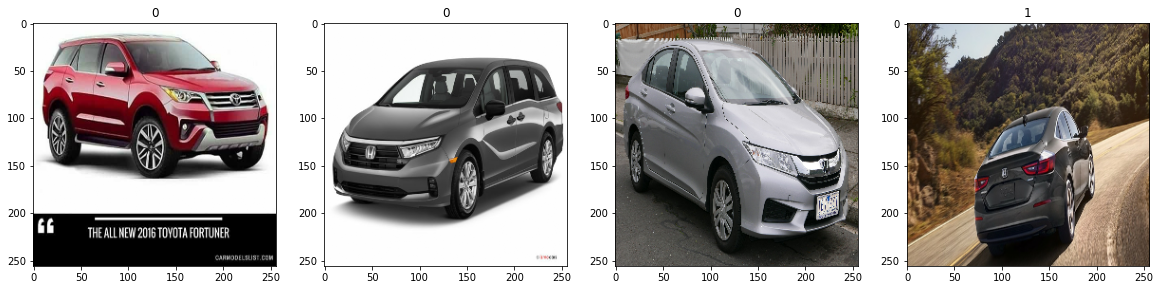

In [70]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][12:16]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

# Step 2: Preprocess Data

## 2.1 Scale Data

In [29]:
data = data.map(lambda x, y: (x/255, y))

In [31]:
scaled_iterator = data.as_numpy_iterator()
scaled_iterator.next()[0].min()

0.0

## 2.2 Split Data

In [32]:
len(data)

38

In [41]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1) + 1

In [42]:
train_size, val_size, test_size

(26, 8, 4)

In [43]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [44]:
len(train), len(val), len(test)

(26, 8, 4)

# Step 3: Deep Model

## 3.1 Build Deep Learning Model

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [155]:
model = Sequential()

In [156]:
model.add(Conv2D(16, (3,3),1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3),1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3),1, activation='relu'))
model.add(MaxPooling2D())


model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [157]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [158]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

## 3.2 Train

In [159]:
log_dir = "/content/drive/MyDrive/Colab Notebooks/CNNToyotaHondaBinaryClassifier/logs"

In [160]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [161]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
26/26 [==============================] - 18s 588ms/step - loss: 0.7054 - accuracy: 0.5373 - val_loss: 0.6693 - val_accuracy: 0.6133
Epoch 2/20
26/26 [==============================] - 18s 625ms/step - loss: 0.6516 - accuracy: 0.6298 - val_loss: 0.6307 - val_accuracy: 0.5977
Epoch 3/20
26/26 [==============================] - 17s 583ms/step - loss: 0.5467 - accuracy: 0.7212 - val_loss: 0.5438 - val_accuracy: 0.7227
Epoch 4/20
26/26 [==============================] - 17s 587ms/step - loss: 0.3866 - accuracy: 0.8401 - val_loss: 0.4676 - val_accuracy: 0.7891
Epoch 5/20
26/26 [==============================] - 17s 588ms/step - loss: 0.2870 - accuracy: 0.8822 - val_loss: 0.4675 - val_accuracy: 0.7852
Epoch 6/20
26/26 [==============================] - 17s 591ms/step - loss: 0.2131 - accuracy: 0.9135 - val_loss: 0.4281 - val_accuracy: 0.8281
Epoch 7/20
26/26 [==============================] - 17s 593ms/step - loss: 0.1228 - accuracy: 0.9627 - val_loss: 0.4655 - val_accuracy: 0.8516

## 3.3 Plot Performance

In [162]:
def learning_curve(history, epoch):
  # training vs validation accuracy
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])

  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # training vs validation loss
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])

  plt.title('Model Accuracy')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

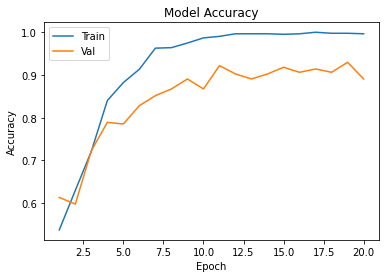

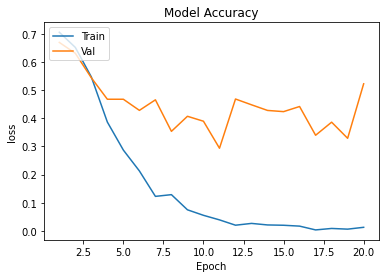

In [164]:
learning_curve(hist, 20)

# Step 4: Evaluate Performance

## 4.1 Evaluate

In [165]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [166]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [167]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [168]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.81666666, shape=(), dtype=float32) tf.Tensor(0.8909091, shape=(), dtype=float32) tf.Tensor(0.84375, shape=(), dtype=float32)


## 4.2 Test

In [169]:
import cv2

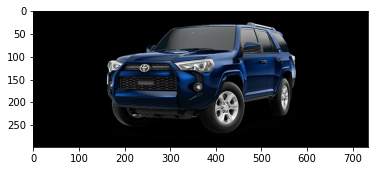

In [170]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/CNNToyotaHondaBinaryClassifier/toyota_test3.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

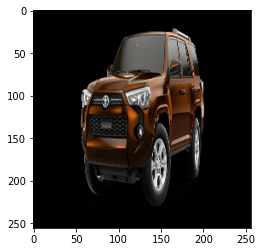

In [171]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [172]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [173]:
yhat

array([[0.0195493]], dtype=float32)

In [174]:
if yhat> 0.5:
  print("Honda")
else:
  print("Toyota")

Toyota


# Step 5: Save the Model

## 5.1 Save the model

In [175]:
from tensorflow.keras.models import load_model

In [176]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/CostumeCNNImageClassifier/models'
model.save(os.path.join(model_dir, 'happysadmodel.h5'))

In [177]:
new_model = load_model(os.path.join(model_dir, 'happysadmodel.h5'))

In [ ]:
new_model

In [178]:
yhat = new_model.predict(np.expand_dims(resize/255, 0))

In [179]:
yhat

array([[0.0195493]], dtype=float32)